In [1]:
from buildstock_query import BuildStockQuery
import pandas as pd
import os
os.environ['AWS_PROFILE'] = "nrel-aws-resbldg"
os.environ['AWS_DEFAULT_REGION'] = "us-west-2"
## annual table - from SQL
## timeseries tables - from timeseries (8760)

c:\Users\pshrest2\Anaconda3\envs\buildstock_query\lib\site-packages\pydantic\_internal\_config.py:269: UserWarning: Valid config keys have changed in V2:
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)
c:\Users\pshrest2\Anaconda3\envs\buildstock_query\lib\site-packages\pydantic\_internal\_config.py:269: UserWarning: Valid config keys have changed in V2:
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)
c:\Users\pshrest2\Anaconda3\envs\buildstock_query\lib\site-packages\pydantic\_internal\_config.py:269: UserWarning: Valid config keys have changed in V2:
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


# Query:

In [2]:
my_run = BuildStockQuery(db_name='gashpwh',
                        table_name='icf',
                        workgroup='gashpwh',
                        buildstock_type='resstock')

INFO:buildstock_query.query_core:Loading icf ...
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:buildstock_query.query_core:3 queries cache read from icf_query_cache.pkl.
INFO:buildstock_query.query_core:3 queries cache is updated.
INFO:buildstock_query.main:Getting Success counts...
INFO:buildstock_query.report_query:Checking integrity with ts_tables ...
INFO:buildstock_query.query_core:3 queries cache saved to icf_query_cache.pkl


        Fail  Invalid Success    Sum
upgrade                             
0         42        0   15955  15997
Annual and timeseries tables are verified to have the same number of buildings.
All buildings are verified to have the same number of (8760) timeseries rows.


# Dataframe from Query:

In [3]:
res_df = my_run.get_results_csv()
res_df.columns
res_df.shape

INFO:buildstock_query.main:Making results_csv query ...
c:\Users\pshrest2\Anaconda3\envs\buildstock_query\lib\site-packages\pyathena\pandas\result_set.py:273: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(
c:\Users\pshrest2\Anaconda3\envs\buildstock_query\lib\site-packages\pyathena\pandas\result_set.py:273: DtypeWarning: Columns (10,183,184,185,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,481,482,505,521) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(


(15997, 545)

# Basic filtering example:
df = res_df.filter(regex='report_simulation_output.emissions')

# Dataframe for emissions:

In [4]:
# # Creating a list of columns to keep in the res_df dataframe:
# regex_patterns = ['report_simulation_output.emissions',
# 'build_existing_model.cec_climate_zone',
# 'build_existing_model.geometry_stories',
# 'build_existing_model.heating_fuel',
# 'build_existing_model.hot_water_distribution',
# 'build_existing_model.hot_water_fixtures',
# 'build_existing_model.hvac_heating_type_and_fuel',
# 'build_existing_model.income_recs_2020',
# 'build_existing_model.occupants',
# 'build_existing_model.sample_weight',
# 'build_existing_model.vacancy_status',
# 'build_existing_model.vintage',
# 'build_existing_model.water_heater_efficiency',
# 'build_existing_model.water_heater_fuel',
# 'build_existing_model.water_heater_in_unit',
# 'report_simulation_output.fuel_use',
# 'report_simulation_output.load_hot_water_tank_losses_m_btu',
# 'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_wood_pellets_total_lb',
# 'report_simulation_output.fuel_use_electricity_total_m_btu',
# 'report_simulation_output.fuel_use_fuel_oil_total_m_btu',
# 'report_simulation_output.fuel_use_natural_gas_total_m_btu',
# 'report_simulation_output.fuel_use_natural_gas_total_m_btu',
# 'report_simulation_output.fuel_use_propane_total_m_btu',
# 'report_simulation_output.fuel_use_wood_cord_total_m_btu',
# 'report_simulation_output.fuel_use_wood_pellets_total_m_btu'

# ]

# Creating a list of columns to keep in the res_df dataframe:
regex_patterns = [
    
    # 'report_simulation_output.emissions',
'build_existing_model.cec_climate_zone',
'build_existing_model.geometry_stories',
'build_existing_model.sample_weight',
'build_existing_model.occupants',
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb',

# Totals by fuel type:
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_total_lb', # For Fuel Type Electricity Total
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_total_lb', # For Fuel Type Natural Gas Total
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_total_lb', # For Fuel Type Propane Total

# Heating, electricity:
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_fans_pumps_lb', # For Heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_heat_pump_backup_fans_pumps_lb', # For Heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_heat_pump_backup_lb', # For Heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_lb', # For Heating by fuel type electricity

# Water Heating, electricity:
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_lb', # For water heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_recirc_pump_lb', # For water heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_solar_thermal_pump_lb', # For water heating by fuel type electricity

# Heating, natural gas:
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_heating_heat_pump_backup_lb', # For Heating by fuel type natural gas
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_heating_lb', # For Heating by fuel type natural gas

# Water Heating, natural gas:
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_hot_water_lb', # For water heating by fuel type natural gas

# Heating, propane:
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_heating_heat_pump_backup_lb', # For heating by fuel type Propane
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_heating_lb', # For heating by fuel type Propane

# Water Heating, propane:
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_hot_water_lb' # For water heating by fuel type propane

]

filtered_dfs = [res_df.filter(regex=pattern) for pattern in regex_patterns]
df = pd.concat(filtered_dfs, axis=1)
df = df[df['build_existing_model.geometry_stories'].astype(float) <= 5.0]  # Limiting to <= 5 stories high
# Convert the column to numeric (integer)
df['build_existing_model.cec_climate_zone'] = df['build_existing_model.cec_climate_zone'].astype(int)

print(df['build_existing_model.geometry_stories'])
df.shape

building_id
51        2
76        3
130       2
224       2
271       2
         ..
549843    3
549856    1
549858    3
549867    1
549895    2
Name: build_existing_model.geometry_stories, Length: 14173, dtype: object


(14173, 22)

In [5]:
# Outputting the full emissions dataset for easy viewing:
df.to_csv('emissions/df.csv', index=False)
res_df.to_csv('emissions/res_df.csv', index=False)

In [6]:
# Total CO2e number across all homes:
totalCO2e = "{:e}".format(df['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb'].sum())
print("total CO2e, lb = ", totalCO2e)

# Converting to metric tons:
# 1 pound = 0.00045359237 metric tons
print("total MtCO2e = ", (df['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb'].sum())*0.00045359237)

total CO2e, lb =  6.150304e+07
total MtCO2e =  27897.309122422106


# Sanity check plot

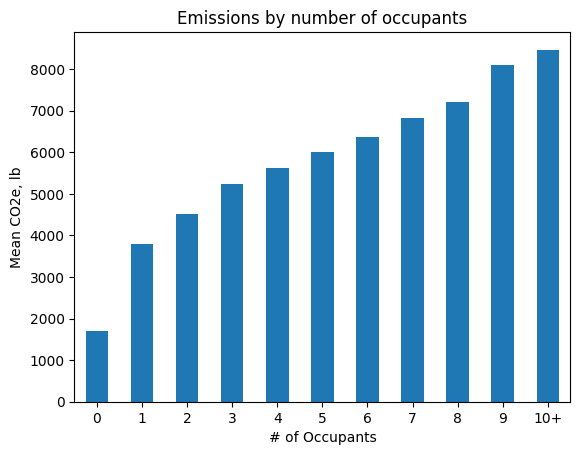

In [7]:
import matplotlib.pyplot as plt

grouped = df.groupby('build_existing_model.occupants')['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb'].mean()

# Sort the data based on the mean values in ascending order
grouped_sorted = grouped.sort_values()

# Generate bar graph for each group
ax = grouped_sorted.plot(kind='bar')
plt.ylabel('Mean CO2e, lb')
plt.xlabel('# of Occupants')
plt.title('Emissions by number of occupants')
ax.set_xticklabels(grouped_sorted.index, rotation=0)
plt.show()

# Actual plots

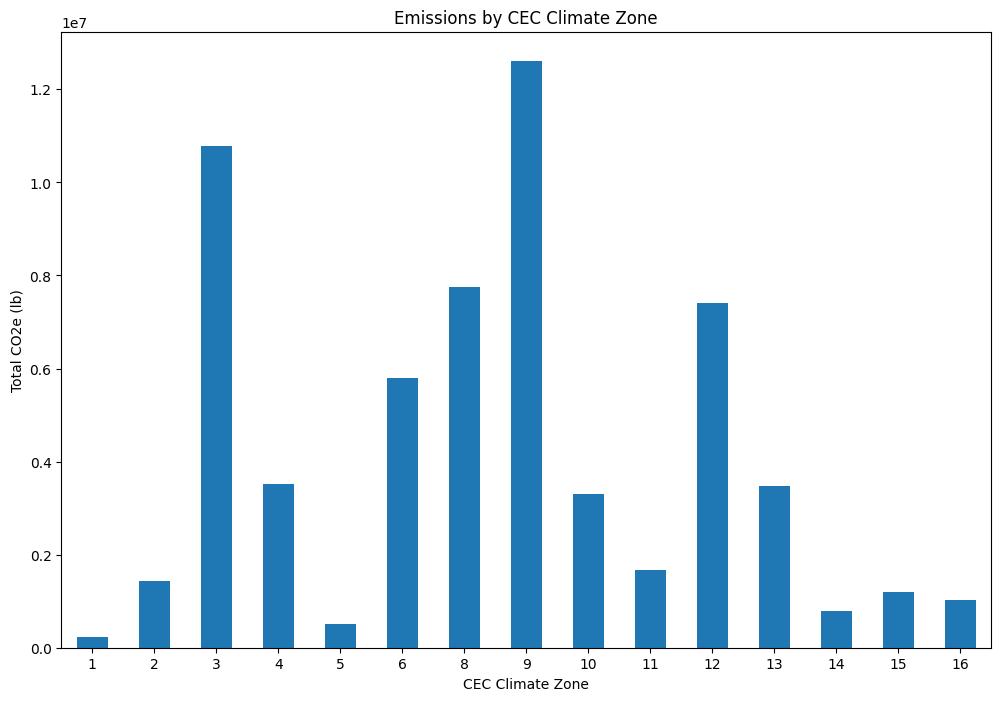

In [8]:
# Total CO2e emission by climate zone:

import matplotlib.pyplot as plt


grouped= df.groupby('build_existing_model.cec_climate_zone')['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb'].sum()

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)  # Adjust figsize as needed

# Generate bar graph for each group
ax = grouped.plot(kind='bar')
plt.ylabel('Total CO2e (lb)')
plt.xlabel('CEC Climate Zone')
plt.title('Emissions by CEC Climate Zone')

# Disable the legend
ax.legend().set_visible(False)

# Set custom x-tick positions and labels
xtick_positions = range(len(grouped.index))
xtick_labels = grouped.index

plt.xticks(xtick_positions, xtick_labels, rotation=0)

plt.show()


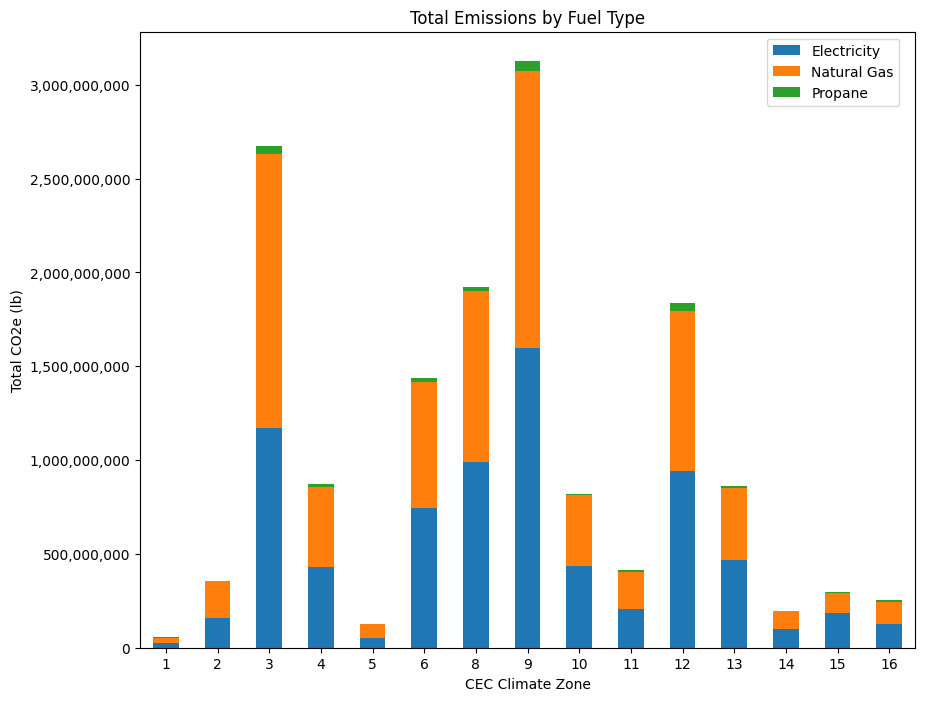

In [9]:
# Total Emissions by fuel type:

regex_patterns = [
    # 'report_simulation_output.emissions',
'build_existing_model.cec_climate_zone',
'build_existing_model.geometry_stories',
'build_existing_model.sample_weight',
'build_existing_model.occupants',
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb',

# Totals by fuel type:
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_total_lb', # For Fuel Type Electricity Total
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_total_lb', # For Fuel Type Natural Gas Total
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_total_lb', # For Fuel Type Propane Total

# Heating, electricity:
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_fans_pumps_lb', # For Heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_heat_pump_backup_fans_pumps_lb', # For Heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_heat_pump_backup_lb', # For Heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_lb', # For Heating by fuel type electricity

# Water Heating, electricity:
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_lb', # For water heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_recirc_pump_lb', # For water heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_solar_thermal_pump_lb', # For water heating by fuel type electricity

# Heating, natural gas:
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_heating_heat_pump_backup_lb', # For Heating by fuel type natural gas
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_heating_lb', # For Heating by fuel type natural gas

# Water Heating, natural gas:
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_hot_water_lb', # For water heating by fuel type natural gas

# Heating, propane:
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_heating_heat_pump_backup_lb', # For heating by fuel type Propane
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_heating_lb', # For heating by fuel type Propane

# Water Heating, propane:
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_hot_water_lb' # For water heating by fuel type propane

]

# Filter out rows with the specified column value
#df_filtered = df[df['build_existing_model.heating_fuel'] != 'None']

df_total = df 
df_total['total'] = (df_total['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_total_lb'] + \
    df_total['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_total_lb'] + \
        df_total['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_total_lb'])



# Convert the column to numeric (integer)
grouped_by_electricity = df_total.groupby(['build_existing_model.cec_climate_zone'])['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_total_lb'].sum()
grouped_by_natural_gas = df_total.groupby(['build_existing_model.cec_climate_zone'])['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_total_lb'].sum()
grouped_by_propane = df_total.groupby(['build_existing_model.cec_climate_zone'])['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_total_lb'].sum()

grouped_by_all = pd.DataFrame(
    {
        'Electricity': grouped_by_electricity*248,
        'Natural Gas': grouped_by_natural_gas*248,
        'Propane': grouped_by_propane*248
    }
)
grouped_by_all


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Set the inline backend and desired figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)  # Adjust figsize as needed


ax = grouped_by_all.plot(kind='bar', stacked=True)
plt.xlabel('CEC Climate Zone')
plt.ylabel('Total CO2e (lb)')
plt.title('Total Emissions by Fuel Type')
plt.xticks(rotation=0)

# Move the legend to the right by adjusting bbox_to_anchor
plt.legend(title='', bbox_to_anchor=(0.8, 1), loc='upper left')

# Format y-axis tick labels with commas
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


plt.show()


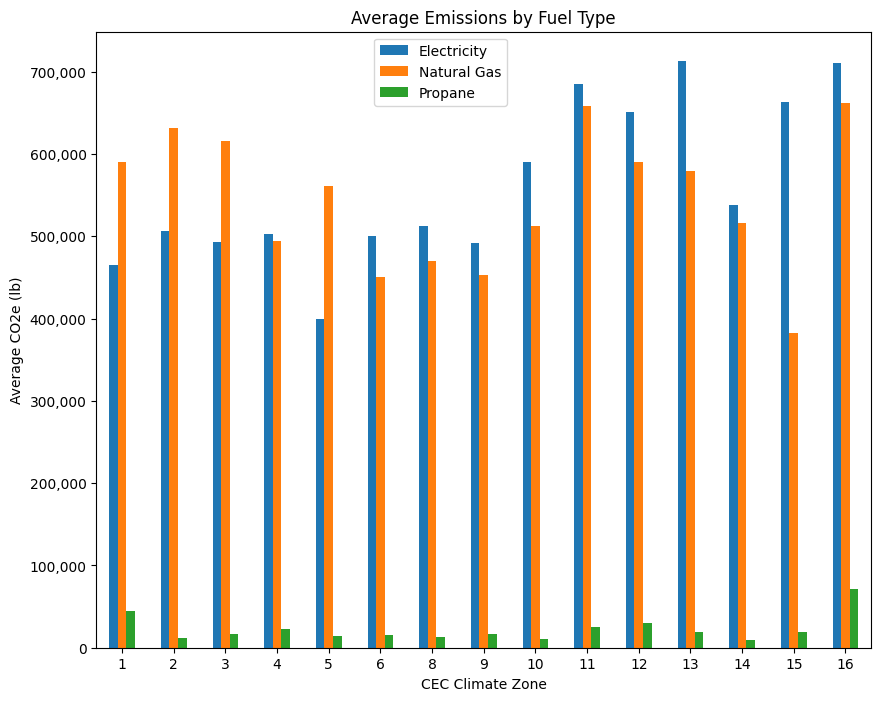

In [10]:
# Convert the column to numeric (integer)
grouped_by_electricity = df_total.groupby(['build_existing_model.cec_climate_zone'])['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_total_lb'].mean()
grouped_by_natural_gas = df_total.groupby(['build_existing_model.cec_climate_zone'])['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_total_lb'].mean()
grouped_by_propane = df_total.groupby(['build_existing_model.cec_climate_zone'])['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_total_lb'].mean()

grouped_by_all = pd.DataFrame(
    {
        'Electricity': grouped_by_electricity*248,
        'Natural Gas': grouped_by_natural_gas*248,
        'Propane': grouped_by_propane*248
    }
)
grouped_by_all


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Set the inline backend and desired figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)  # Adjust figsize as needed


ax = grouped_by_all.plot(kind='bar', stacked=False)
plt.xlabel('CEC Climate Zone')
plt.ylabel('Average CO2e (lb)')
plt.title('Average Emissions by Fuel Type')
plt.xticks(rotation=0)

# Move the legend to the right by adjusting bbox_to_anchor
plt.legend(title='', bbox_to_anchor=(0.35, 1), loc='upper left')

# Format y-axis tick labels with commas
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


plt.show()

In [12]:
# Stacked bar charts comparing water heater and HVAC emissions:

# import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker

# # Set the inline backend and desired figure size
# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10, 8)  # Adjust figsize as needed
# # Create a figure with the specified DPI
# plt.figure(dpi=500)

# # Filter out rows with the specified column value
# df_filtered = df[df['build_existing_model.heating_fuel'] != 'None']
# df_filtered = df_filtered[df_filtered['build_existing_model.water_heater_fuel'] != 'None']
# df_filtered = df_filtered[df_filtered['build_existing_model.heating_fuel'] != 'Other Fuel']
# df_filtered = df_filtered[df_filtered['build_existing_model.water_heater_fuel'] != 'Other Fuel']

# grouped_wh = df_filtered.groupby(['build_existing_model.water_heater_fuel'])['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb'].sum()
# grouped_hvac = df_filtered.groupby(['build_existing_model.heating_fuel'])['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb'].sum()

# desired_column_order = ['Electricity', 'Natural Gas', 'Propane']

# values_wh = grouped_wh[desired_column_order]
# values_hvac = grouped_hvac[desired_column_order]

# #####################################################

# plot_df = pd.DataFrame({'HVAC': values_hvac, 'Water': values_wh})


# plot_df = plot_df.transpose() # Toggle commenting for error checking
# # column_sums = plot_df.sum() # Toggle commenting for error checking
# # plot_df.loc['Total'] = column_sums # Toggle commenting for error checking
# print(plot_df)

# # Create a stacked bar chart
# ax = plot_df.plot.bar(stacked=True, figsize=(8, 6))

# # Add labels and title
# plt.xlabel('Heating Category')
# plt.ylabel('Total CO2e (lb)')
# plt.title('Total Emissions by HVAC and Water Heater Fuel Types')
# plt.legend(title='Fuel')

# plt.xticks(rotation=0)
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# # Move the legend to the right by adjusting bbox_to_anchor
# plt.legend(title='', bbox_to_anchor=(0.38, 1), loc='upper left')

# # Show the plot
# plt.show()

# # 59,541,628.08

In [14]:
# Multiple bar charts comparing water heater and HVAC emissions:

# import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker

# # Set the inline backend and desired figure size
# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10, 8)  # Adjust figsize as needed
# # Create a figure with the specified DPI
# plt.figure(dpi=500)

# # Filter out rows with the specified column value
# df_filtered = df[df['build_existing_model.heating_fuel'] != 'None']
# df_filtered = df_filtered[df_filtered['build_existing_model.water_heater_fuel'] != 'None']
# df_filtered = df_filtered[df_filtered['build_existing_model.heating_fuel'] != 'Other Fuel']
# df_filtered = df_filtered[df_filtered['build_existing_model.water_heater_fuel'] != 'Other Fuel']


# grouped_wh = df_filtered.groupby(['build_existing_model.water_heater_fuel'])['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb'].mean()
# grouped_hvac = df_filtered.groupby(['build_existing_model.heating_fuel'])['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb'].mean()

# desired_column_order = ['Electricity', 'Natural Gas', 'Propane']

# values_wh = grouped_wh[desired_column_order]*248
# values_hvac = grouped_hvac[desired_column_order]*248

# #####################################################

# plot_df = pd.DataFrame({'HVAC': values_hvac, 'Water': values_wh})
# plot_df = plot_df.transpose()

# # column_sums = plot_df.sum()
# # plot_df.loc['Total'] = column_sums
# print(plot_df)

# # Create a stacked bar chart
# ax = plot_df.plot.bar(stacked=False, figsize=(8, 6))

# # Add labels and title
# plt.xlabel('Heating Category')
# plt.ylabel('Average CO2e (lb)')
# plt.title('Average Emissions by HVAC and Water Heater Fuel Types')
# plt.legend(title='Fuel')

# plt.xticks(rotation=0)
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# # Show the plot
# plt.show()

In [15]:
# Total Emissions by fuel type:

regex_patterns = [
    # 'report_simulation_output.emissions',
'build_existing_model.cec_climate_zone',
'build_existing_model.geometry_stories',
'build_existing_model.sample_weight',
'build_existing_model.occupants',
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb',

# Totals by fuel type: *
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_total_lb', # For Fuel Type Electricity Total
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_total_lb', # For Fuel Type Natural Gas Total
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_total_lb', # For Fuel Type Propane Total

# Heating, electricity: *
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_fans_pumps_lb', # For Heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_heat_pump_backup_fans_pumps_lb', # For Heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_heat_pump_backup_lb', # For Heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_lb', # For Heating by fuel type electricity

# Water Heating, electricity: *
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_lb', # For water heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_recirc_pump_lb', # For water heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_solar_thermal_pump_lb', # For water heating by fuel type electricity

# Heating, natural gas: *
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_heating_heat_pump_backup_lb', # For Heating by fuel type natural gas
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_heating_lb', # For Heating by fuel type natural gas

# Water Heating, natural gas: *
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_hot_water_lb', # For water heating by fuel type natural gas

# Heating, propane: *
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_heating_heat_pump_backup_lb', # For heating by fuel type Propane
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_heating_lb', # For heating by fuel type Propane

# Water Heating, propane: *
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_hot_water_lb' # For water heating by fuel type propane

]

# Filter out rows with the specified column value
#df_filtered = df[df['build_existing_model.heating_fuel'] != 'None']

df_hvac = df 
df_hvac['electricity'] = df_hvac['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_fans_pumps_lb'] + \
    df_hvac['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_heat_pump_backup_fans_pumps_lb'] + \
        df_hvac['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_heat_pump_backup_lb'] + \
            df_hvac['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_lb']

df_hvac['natural_gas'] = df_hvac['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_heating_heat_pump_backup_lb'] + \
    df_hvac['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_heating_lb']

df_hvac['propane'] = df_hvac['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_heating_heat_pump_backup_lb'] + \
    df_hvac['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_heating_lb']

df_wh = df
df_wh['electricity'] = df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_lb'] + \
    df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_recirc_pump_lb'] + \
        df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_solar_thermal_pump_lb']

df_wh['natural_gas'] = df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_hot_water_lb']

df_wh['propane'] = df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_hot_water_lb']



# Convert the column to numeric (integer)
hvac_grouped_by_electricity = df_hvac.groupby(['build_existing_model.cec_climate_zone'])['electricity'].sum()
hvac_grouped_by_natural_gas = df_hvac.groupby(['build_existing_model.cec_climate_zone'])['natural_gas'].sum()
hvac_grouped_by_propane = df_hvac.groupby(['build_existing_model.cec_climate_zone'])['propane'].sum()

wh_grouped_by_electricity = df_wh.groupby(['build_existing_model.cec_climate_zone'])['electricity'].sum()
wh_grouped_by_natural_gas = df_wh.groupby(['build_existing_model.cec_climate_zone'])['natural_gas'].sum()
wh_grouped_by_propane = df_wh.groupby(['build_existing_model.cec_climate_zone'])['propane'].sum()

grouped_by_hvac = pd.DataFrame(
    {
        'Electricity': hvac_grouped_by_electricity*248,
        'Natural Gas': hvac_grouped_by_natural_gas*248,
        'Propane': hvac_grouped_by_propane*248
    }
)

grouped_by_wh = pd.DataFrame(
    {
        'Electricity': wh_grouped_by_electricity*248,
        'Natural Gas': wh_grouped_by_natural_gas*248,
        'Propane': wh_grouped_by_propane*248
    }
)




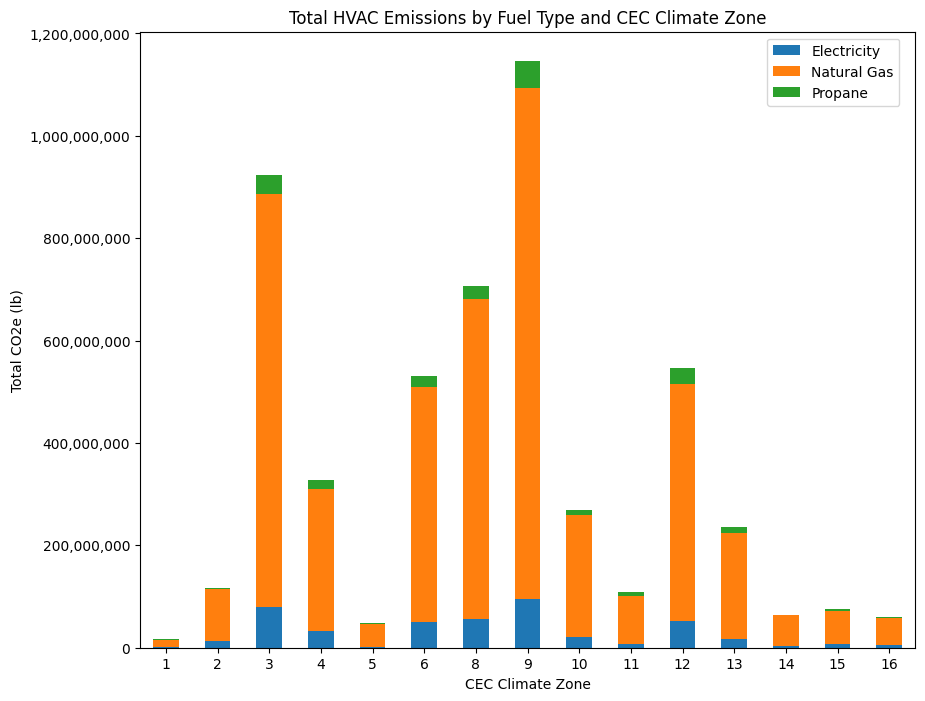

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Set the inline backend and desired figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)  # Adjust figsize as needed


ax = grouped_by_hvac.plot(kind='bar', stacked=True)
plt.xlabel('CEC Climate Zone')
plt.ylabel('Total CO2e (lb)')
plt.title('Total HVAC Emissions by Fuel Type and CEC Climate Zone')
plt.xticks(rotation=0)

# Move the legend to the right by adjusting bbox_to_anchor
plt.legend(title='', bbox_to_anchor=(0.8, 1), loc='upper left')

# Format y-axis tick labels with commas
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


plt.show()

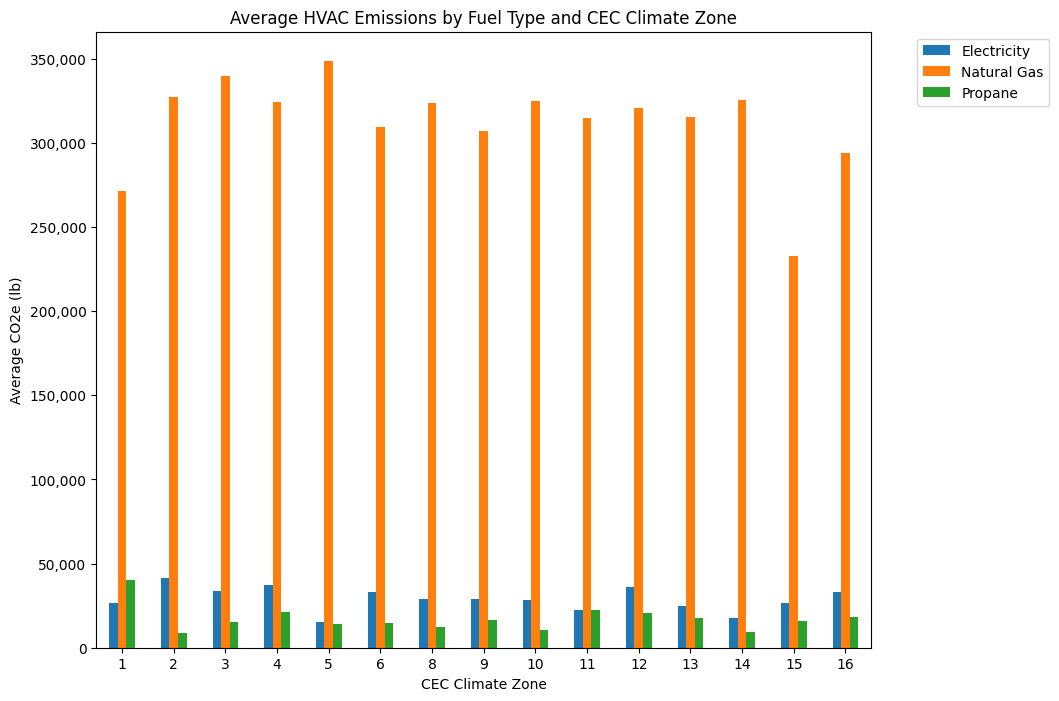

In [17]:

# Convert the column to numeric (integer)
hvac_grouped_by_electricity = df_hvac.groupby(['build_existing_model.cec_climate_zone'])['electricity'].mean()
hvac_grouped_by_natural_gas = df_hvac.groupby(['build_existing_model.cec_climate_zone'])['natural_gas'].mean()
hvac_grouped_by_propane = df_hvac.groupby(['build_existing_model.cec_climate_zone'])['propane'].mean()

wh_grouped_by_electricity = df_wh.groupby(['build_existing_model.cec_climate_zone'])['electricity'].mean()
wh_grouped_by_natural_gas = df_wh.groupby(['build_existing_model.cec_climate_zone'])['natural_gas'].mean()
wh_grouped_by_propane = df_wh.groupby(['build_existing_model.cec_climate_zone'])['propane'].mean()

grouped_by_hvac = pd.DataFrame(
    {
        'Electricity': hvac_grouped_by_electricity*248,
        'Natural Gas': hvac_grouped_by_natural_gas*248,
        'Propane': hvac_grouped_by_propane*248
    }
)

grouped_by_wh = pd.DataFrame(
    {
        'Electricity': wh_grouped_by_electricity*248,
        'Natural Gas': wh_grouped_by_natural_gas*248,
        'Propane': wh_grouped_by_propane*248
    }
)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Set the inline backend and desired figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)  # Adjust figsize as needed


ax = grouped_by_hvac.plot(kind='bar', stacked=False)
plt.xlabel('CEC Climate Zone')
plt.ylabel('Average CO2e (lb)')
plt.title('Average HVAC Emissions by Fuel Type and CEC Climate Zone')
plt.xticks(rotation=0)

# Move the legend to the right by adjusting bbox_to_anchor
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Format y-axis tick labels with commas
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


plt.show()

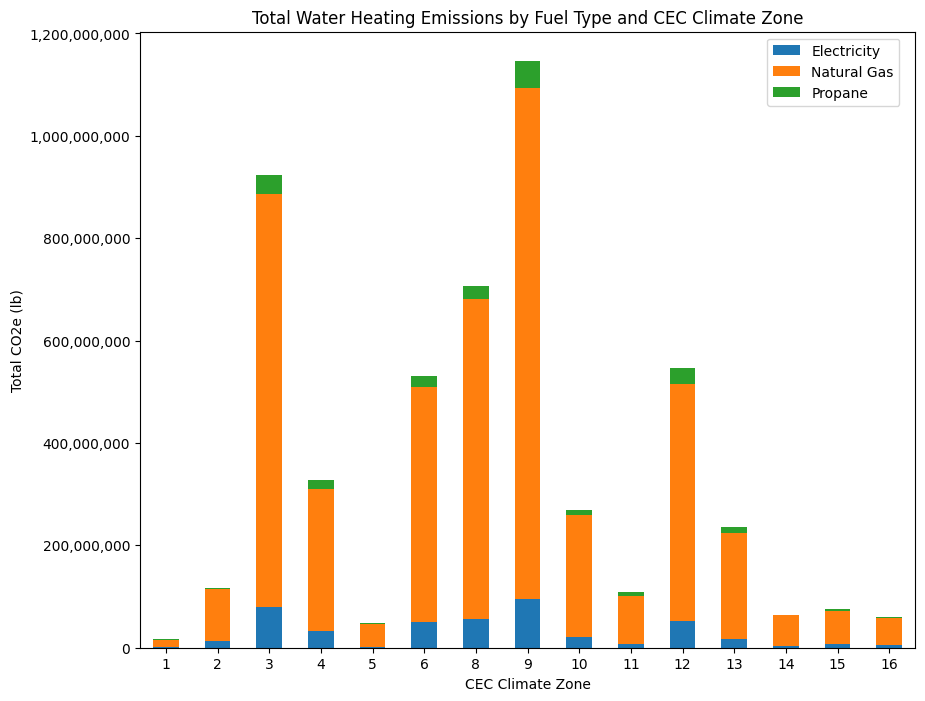

In [18]:


df_wh = df
df_wh['electricity'] = df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_lb'] + \
    df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_recirc_pump_lb'] + \
        df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_solar_thermal_pump_lb']

df_wh['natural_gas'] = df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_hot_water_lb']

df_wh['propane'] = df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_hot_water_lb']





wh_grouped_by_electricity = df_wh.groupby(['build_existing_model.cec_climate_zone'])['electricity'].sum()
wh_grouped_by_natural_gas = df_wh.groupby(['build_existing_model.cec_climate_zone'])['natural_gas'].sum()
wh_grouped_by_propane = df_wh.groupby(['build_existing_model.cec_climate_zone'])['propane'].sum()



grouped_by_wh = pd.DataFrame(
    {
        'Electricity': wh_grouped_by_electricity*248,
        'Natural Gas': wh_grouped_by_natural_gas*248,
        'Propane': wh_grouped_by_propane*248
    }
)


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Set the inline backend and desired figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)  # Adjust figsize as needed


ax = grouped_by_wh.plot(kind='bar', stacked=True)
plt.xlabel('CEC Climate Zone')
plt.ylabel('Total CO2e (lb)')
plt.title('Total Water Heating Emissions by Fuel Type and CEC Climate Zone')
plt.xticks(rotation=0)

# Move the legend to the right by adjusting bbox_to_anchor
plt.legend(title='', bbox_to_anchor=(0.8, 1), loc='upper left')

# Format y-axis tick labels with commas
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


plt.show()


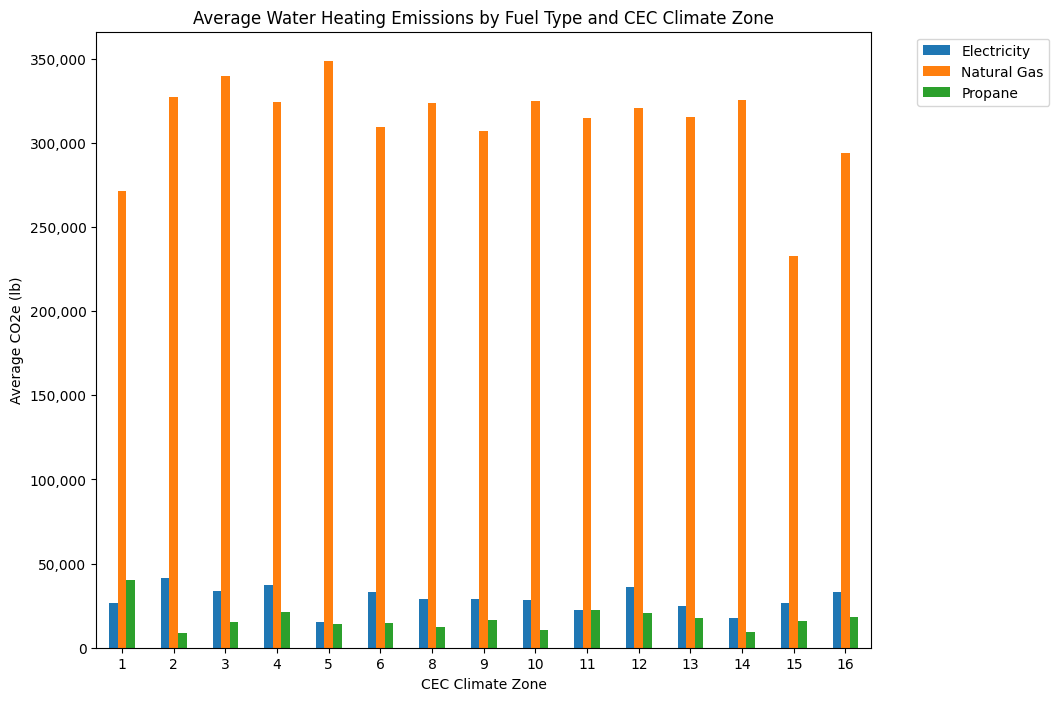

In [19]:

df_wh = df
df_wh['electricity'] = df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_lb'] + \
    df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_recirc_pump_lb'] + \
        df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_solar_thermal_pump_lb']

df_wh['natural_gas'] = df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_hot_water_lb']

df_wh['propane'] = df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_hot_water_lb']



wh_grouped_by_electricity = df_wh.groupby(['build_existing_model.cec_climate_zone'])['electricity'].mean()
wh_grouped_by_natural_gas = df_wh.groupby(['build_existing_model.cec_climate_zone'])['natural_gas'].mean()
wh_grouped_by_propane = df_wh.groupby(['build_existing_model.cec_climate_zone'])['propane'].mean()



grouped_by_wh = pd.DataFrame(
    {
        'Electricity': wh_grouped_by_electricity*248,
        'Natural Gas': wh_grouped_by_natural_gas*248,
        'Propane': wh_grouped_by_propane*248
    }
)


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Set the inline backend and desired figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)  # Adjust figsize as needed


ax = grouped_by_wh.plot(kind='bar', stacked=False)
plt.xlabel('CEC Climate Zone')
plt.ylabel('Average CO2e (lb)')
plt.title('Average Water Heating Emissions by Fuel Type and CEC Climate Zone')
plt.xticks(rotation=0)

# Move the legend to the right by adjusting bbox_to_anchor
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Format y-axis tick labels with commas
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


plt.show()

In [40]:
# Total Emissions by fuel type:

regex_patterns = [
    # 'report_simulation_output.emissions',
'build_existing_model.cec_climate_zone',
'build_existing_model.geometry_stories',
'build_existing_model.sample_weight',
'build_existing_model.occupants',
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb',

# Totals by fuel type: *
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_total_lb', # For Fuel Type Electricity Total
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_total_lb', # For Fuel Type Natural Gas Total
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_total_lb', # For Fuel Type Propane Total

# Heating, electricity: *
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_fans_pumps_lb', # For Heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_heat_pump_backup_fans_pumps_lb', # For Heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_heat_pump_backup_lb', # For Heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_lb', # For Heating by fuel type electricity

# Water Heating, electricity: *
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_lb', # For water heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_recirc_pump_lb', # For water heating by fuel type electricity
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_solar_thermal_pump_lb', # For water heating by fuel type electricity

# Heating, natural gas: *
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_heating_heat_pump_backup_lb', # For Heating by fuel type natural gas
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_heating_lb', # For Heating by fuel type natural gas

# Water Heating, natural gas: *
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_hot_water_lb', # For water heating by fuel type natural gas

# Heating, propane: *
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_heating_heat_pump_backup_lb', # For heating by fuel type Propane
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_heating_lb', # For heating by fuel type Propane

# Water Heating, propane: *
'report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_hot_water_lb' # For water heating by fuel type propane

]

# Filter out rows with the specified column value
#df_filtered = df[df['build_existing_model.heating_fuel'] != 'None']

df_hvac = df 
df_hvac['electricity'] = df_hvac['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_fans_pumps_lb'] + \
    df_hvac['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_heat_pump_backup_fans_pumps_lb'] + \
        df_hvac['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_heat_pump_backup_lb'] + \
            df_hvac['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_lb']

df_hvac['natural_gas'] = df_hvac['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_heating_heat_pump_backup_lb'] + \
    df_hvac['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_heating_lb']

df_hvac['propane'] = df_hvac['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_heating_heat_pump_backup_lb'] + \
    df_hvac['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_heating_lb']

df_wh = df
df_wh['electricity'] = df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_lb'] + \
    df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_recirc_pump_lb'] + \
        df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_hot_water_solar_thermal_pump_lb']

df_wh['natural_gas'] = df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_hot_water_lb']

df_wh['propane'] = df_wh['report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_hot_water_lb']


# selected_columns = ['electricity', 'natural_gas', 'propane']

# df_hvac = df_hvac[selected_columns]
# df_wh = df_wh[selected_columns]

# df_hvac['Use_type'] = 'HVAC'
# df_wh['Use_type'] = 'Water'

df_hvac



,build_existing_model.cec_climate_zone,build_existing_model.geometry_stories,build_existing_model.geometry_stories_low_rise,build_existing_model.sample_weight,build_existing_model.occupants,report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb,report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_total_lb,report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_total_lb,report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_total_lb,report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_electricity_heating_fans_pumps_lb,...,report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_heating_heat_pump_backup_lb,report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_heating_lb,report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_natural_gas_hot_water_lb,report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_heating_heat_pump_backup_lb,report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_heating_lb,report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_propane_hot_water_lb,total,electricity,natural_gas,propane
building_id,,,,,,,,,,,,,,,,,,,,,
51,6,2,2,248.0,7,5753.88,2137.78,3616.10,0.00,0.00,...,0.0,0.00,3006.79,0.0,0.0,0.00,5753.88,0.0,3006.79,0.00
76,9,3,3,248.0,2,2685.32,1033.10,1652.22,0.00,0.38,...,0.0,9.20,1250.46,0.0,0.0,0.00,2685.32,0.0,1250.46,0.00
130,3,2,2,248.0,3,3708.38,1034.38,2674.00,0.00,17.93,...,0.0,1130.07,1328.98,0.0,0.0,0.00,3708.38,0.0,1328.98,0.00
224,12,2,2,248.0,0,1500.23,574.06,926.16,0.00,0.62,...,0.0,133.03,793.13,0.0,0.0,0.00,1500.22,0.0,793.13,0.00
271,6,2,2,248.0,1,5842.30,2026.93,3815.37,0.00,28.13,...,0.0,1380.67,2015.66,0.0,0.0,0.00,5842.30,0.0,2015.66,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549843,10,3,3,248.0,1,5944.95,3037.39,2907.56,0.00,34.29,...,0.0,992.24,1496.28,0.0,0.0,0.00,5944.95,0.0,1496.28,0.00
549856,8,1,1,248.0,2,5738.29,2826.56,0.00,2911.74,0.96,...,0.0,0.00,0.00,0.0,0.0,2911.74,5738.30,0.0,0.00,2911.74
549858,3,3,3,248.0,1,4713.52,1999.71,2713.81,0.00,0.01,...,0.0,0.33,1682.37,0.0,0.0,0.00,4713.52,0.0,1682.37,0.00


In [29]:
# Creating a simplified (grouped) dataframe for stacked bar charts for totals (bar 1 = hvac, bar 2 = water heating):

combined_df = pd.concat([df_hvac, df_wh])

print(combined_df)

# Group by index and sum the values for each column
summed_df = combined_df.groupby('Use_type').sum()

print(summed_df)

             electricity  natural_gas  propane Use_type
building_id                                            
51                   0.0      3006.79     0.00     HVAC
76                   0.0      1250.46     0.00     HVAC
130                  0.0      1328.98     0.00     HVAC
224                  0.0       793.13     0.00     HVAC
271                  0.0      2015.66     0.00     HVAC
...                  ...          ...      ...      ...
549843               0.0      1496.28     0.00    Water
549856               0.0         0.00  2911.74    Water
549858               0.0      1682.37     0.00    Water
549867               0.0      1516.84     0.00    Water
549895               0.0       676.92     0.00    Water

[28346 rows x 4 columns]
          electricity  natural_gas    propane
Use_type                                     
HVAC       1780684.35  18189103.69  912670.88
Water      1780684.35  18189103.69  912670.88


<Figure size 5000x4000 with 0 Axes>

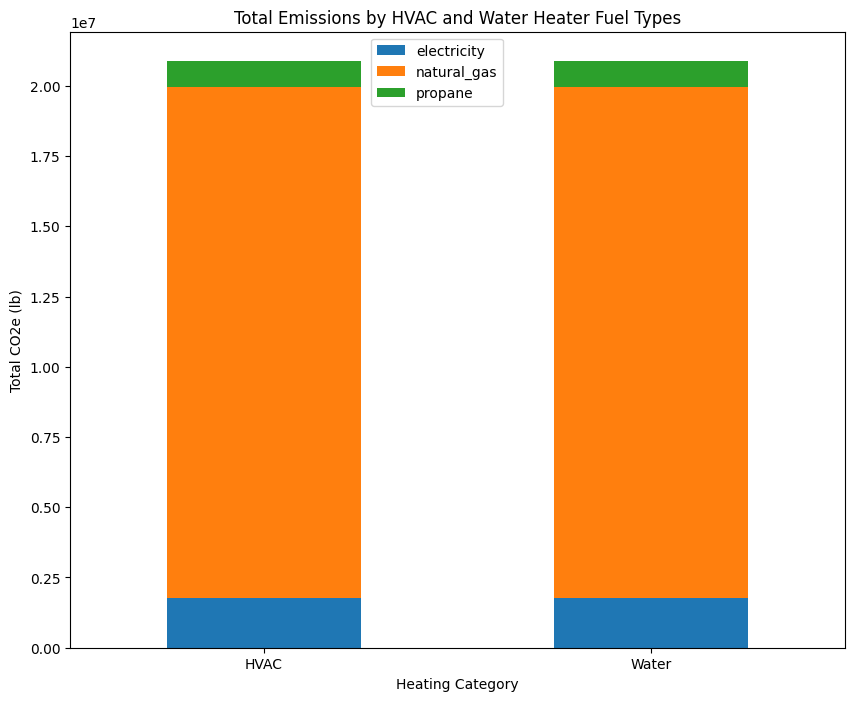

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Set the inline backend and desired figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)  # Adjust figsize as needed
plt.figure(dpi=500)

# Create a stacked bar chart
summed_df.plot(kind='bar',stacked=True)

# Add labels and title
plt.xlabel('Heating Category')
plt.ylabel('Total CO2e (lb)')
plt.title('Total Emissions by HVAC and Water Heater Fuel Types')
plt.legend(title='Fuel')

plt.xticks(rotation=0)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Move the legend to the right by adjusting bbox_to_anchor
plt.legend(title='', bbox_to_anchor=(0.38, 1), loc='upper left')

# Show the plot
plt.show()